In [1]:
import os
import numpy as np
import pandas as pd
from astropy.io import fits as pf
from astropy.stats import sigma_clipped_stats, mad_std
from astropy.io import ascii
from reproject import reproject_interp, reproject_exact
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LogNorm
from ipywidgets import interact
EXACT = True

In [2]:
i = 3
pd_down_res = pd.read_csv("../../data_check/download_est.csv",index_col=0) 
pd_kanata = pd_down_res.loc[(pd_down_res["sub"].str.contains("_S")) & (pd_down_res["telescope"] == "Kanata-HONIR") & (pd_down_res["filter"] == "R")].reset_index(drop=True)
pd_kanata.iloc[i]

original                       uploaded_20190412_21285538.fits
sub          uploaded_20190412_21285538_GL141846plus305225_...
telescope                                         Kanata-HONIR
filter                                                       R
Me_org                                                0.784008
Med_org                                             -0.0151165
Std_org                                               0.793347
Me_sub                                                -8.55059
Med_sub                                                  1e-30
Std_sub                                                5428.64
Name: 3, dtype: object

In [3]:
def get_images(FITS,REFILE,SUBFILE):
    NAME = FITS.replace(".fits","")
    url = os.path.join("http://www.growth-host.phys.sci.titech.ac.jp:8888","jgem")
    url_ori = os.path.join(url,"tmpfits",FITS)
    url_sub = os.path.join(url,"ana",NAME,SUBFILE)
    url_ref = os.path.join(url,"ana",NAME,REFILE)
    cmd = "wget --http-user=jgem --http-password=asakura "+ url_ori
    if not os.path.exists(FITS):
        os.system(cmd)
    cmd = "wget --http-user=jgem --http-password=asakura "+ url_ref
    if not os.path.exists(REFILE):
        os.system(cmd)
    cmd = "wget --http-user=jgem --http-password=asakura "+ url_sub
    if not os.path.exists(SUBFILE):
        os.system(cmd)
    hdu1 = pf.open(FITS)[0]
    hdu2 = pf.open(REFILE)[0]
    hdu3 = pf.open(SUBFILE)[0]
    return hdu1, hdu2, hdu3

In [4]:
FITS, SUBFILE = pd_kanata.iloc[i]["original"], pd_kanata.iloc[i]["sub"]
REFILE = SUBFILE.replace("_trim_sub_hp.fits","_ps1trim.fits")
print("{}\t{}\t{}\t".format(FITS, REFILE, SUBFILE))

uploaded_20190412_21285538.fits	uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits	uploaded_20190412_21285538_GL141846plus305225_S190412m_trim_sub_hp.fits	


In [5]:
hdu1, hdu2, hdu3 = get_images(FITS, REFILE, SUBFILE)
hdu3.header["NAXIS2"]

1021

In [6]:
if EXACT == True:
    array, footprint = reproject_exact(hdu1, hdu2.header)
else:
    array, footprint = reproject_interp(hdu1, hdu2.header)

Set DATE-END to '2019-04-12T16:42:53.021' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-Y to  3867096.147 from OBSGEO-[LBH].
Set OBSGEO-Z to  3583819.361 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [7]:
nx, ny = array.shape
st, en = int(nx / 3.), int(nx * 2. / 3.)
omax, omin = np.max(array[st:en, st:en]), np.min(array[st:en, st:en])
rmax, rmin = np.nanmax(hdu2.data[st:en, st:en]), np.nanmin(hdu2.data[st:en, st:en])
print("Org max:{0:.1f}, Org min:{1:.1f}, Ref max:{2:.1f}, Ref min:{3:.1f}".format(omax, omin, rmax, rmin))

temp = "temp.fits"
if os.path.exists(temp): os.remove(temp)
pf.writeto(temp, array, hdu2.header, overwrite=True)

Org max:13.2, Org min:-2.9, Ref max:13781.4, Ref min:-680.1


In [8]:
hdu = pf.open("temp.fits")[0]
print("original: [{},{}] \t ps1: [{},{}] \t reproject org: [{},{}]".format(hdu1.header["NAXIS1"],hdu1.header["NAXIS2"],hdu2.header["NAXIS1"],hdu2.header["NAXIS2"],hdu.header["NAXIS1"],hdu.header["NAXIS2"]))

original: [2026,2106] 	 ps1: [1022,1021] 	 reproject org: [1022,1021]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


26299.072

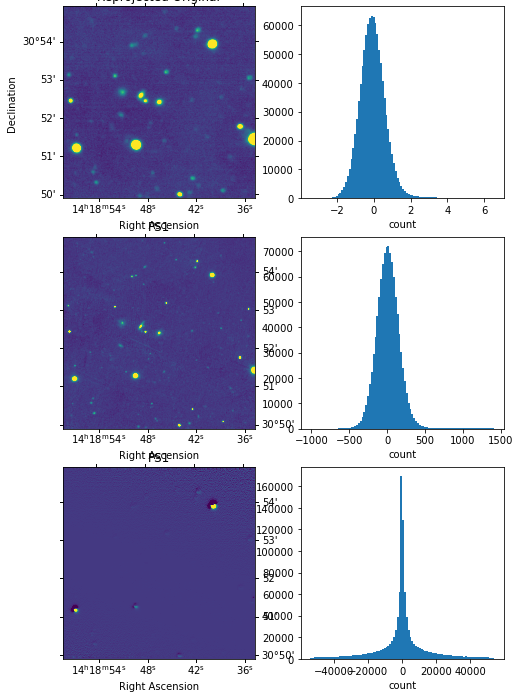

In [9]:
fig = plt.figure(figsize=(8,12))
DATA = array[~np.isnan(array)]
DATA = np.ravel(DATA)
med, std = np.nanmedian(DATA), mad_std(DATA)
ax1 = fig.add_subplot(3, 2, 1, projection=WCS(hdu2.header))
#ax1 = plt.subplot(1,3,1, projection=WCS(hdu2.header))
ax1.imshow(array, origin='lower', vmin=(med-2*std), vmax=(med+10*std))
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected Original')

DATA = DATA[(DATA > med - 10*std) & (DATA < med + 10*std)]
#BIN = np.logspace(np.log10(np.min(DATA)), np.log10(np.max(DATA)), 100)
ax2 = fig.add_subplot(3,2,2)
ax2.hist(DATA, bins=100)
ax2.set_xlabel("count")
#ax2.set_xscale('log')

DATA = hdu2.data[~np.isnan(hdu2.data)]
DATA = np.ravel(DATA)
med, std = np.nanmedian(DATA), mad_std(DATA)
ax3 = fig.add_subplot(3, 2, 3, projection=WCS(hdu2.header))
#ax2 = plt.subplot(1,3,2, projection=WCS(hdu2.header))
ax3.imshow(hdu2.data, origin='lower', vmin=(med-2*std), vmax=(med+10*std))
ax3.coords['ra'].set_axislabel('Right Ascension')
ax3.coords['dec'].set_axislabel('Declination')
ax3.coords['dec'].set_axislabel_position('r')
ax3.coords['dec'].set_ticklabel_position('r')
ax3.set_title('PS1')

DATA = DATA[(DATA > med - 10*std) & (DATA < med + 10*std)]
ax4 = fig.add_subplot(3,2,4)
ax4.hist(DATA, bins=100)
ax4.set_xlabel("count")

DATA = hdu3.data[~np.isnan(hdu3.data)]
DATA = np.ravel(DATA)
med, std = np.nanmedian(DATA), mad_std(DATA)
ax5= fig.add_subplot(3, 2, 5, projection=WCS(hdu2.header))
#ax2 = plt.subplot(1,3,2, projection=WCS(hdu2.header))
ax5.imshow(hdu3.data, origin='lower', vmin=med-2*std, vmax=med+10*std)
ax5.coords['ra'].set_axislabel('Right Ascension')
ax5.coords['dec'].set_axislabel('Declination')
ax5.coords['dec'].set_axislabel_position('r')
ax5.coords['dec'].set_ticklabel_position('r')
ax5.set_title('PS1')

DATA = DATA[(DATA > med - 10*std) & (DATA < med + 10*std)]
ax6 = fig.add_subplot(3,2,6)
ax6.hist(DATA, bins=100)
ax6.set_xlabel("count")
np.nanstd(hdu3.data)

In [10]:
def est_fwhm(fits,conf):
    SE = "/opt/local/bin/sex"
    cmd = "{0} {1} -c {2} -CATALOG_NAME temp.cat".format(SE,fits,conf)
    os.system(cmd)
    fwhm = np.nan
    if os.path.exists("temp.cat"):
        tab = ascii.read("temp.cat")
        os.remove("temp.cat")
        tab = tab[tab["FLAGS"] == 0]
        if len(tab) > 2:
            fwhm = np.nanmedian(tab["FWHM_IMAGE"])
    return fwhm
honir_fwhm = est_fwhm("temp.fits","/Users/sasada/work/sextractor/honir.sex")
ps1_fwhm = est_fwhm(REFILE,"/Users/sasada/work/sextractor/ps1.sex")
print("HONIR FWHM: {} pix \t PS1 FWHM: {} pix".format(honir_fwhm, ps1_fwhm))

HONIR FWHM: 21.95 pix 	 PS1 FWHM: 4.8149999999999995 pix


In [11]:
sigma_match = np.sqrt((np.power(honir_fwhm,2.0) - np.power(ps1_fwhm,2.0)) / (4*2*np.log(2)))
ng = " -ng 3 6 {} 4 {} 2 {}".format(0.5*sigma_match,sigma_match,2.0*sigma_match)
print("HONIR={}\tPS1={}\tSigma_match={}\nng={}".format(honir_fwhm, ps1_fwhm, sigma_match, ng))

HONIR=21.95	PS1=4.8149999999999995	Sigma_match=9.094272311485062
ng= -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124


In [12]:
HOTPANTS = "hotpants"
iu   = 45000.0 # upper limit
il   =  -500.0 # lower limit 
IU = omax + 1000
IL = omin - 500
if "GAIN"    in hdu1.header.keys():gain = hdu1.header['GAIN']
else:                       gain = 1.0 
if 'RONOISE' in hdu1.header.keys():rnoi = hdu1.header['RONOISE']
else:                       rnoi = 1.0 
# for PS1 tempate
tgain = 1.2
trnoi = 5.2
tu   =  700.0
tl   = -700.0
TU = rmax + 1000
TL = rmin - 500
nsx, nsy = 10, 10
def hotpants_sub(Input,Reference,output,iu=iu,il=il,iuk=None,tu=tu,tl=tl,tuk=None,nsx=nsx,nsy=nsy,STR=None):
    if iuk == None: iuk = iu
    if tuk == None: tuk = tu
    command, cmd = [], []
    cmd.append("{} ".format(HOTPANTS))
    cmd.append("-inim {0} -tmplim {1} -outim {2} ".format(temp,Reference,output))
    cmd.append("-iu {0} -il {1} -iuk {2} -ig {3} -ir {4} ".format(str(iu),str(il),str(iuk),str(gain),str(rnoi)))
    cmd.append("-tu {0} -tl {1} -tuk {2} -tg {3} -tr {4} ".format(str(tu),str(tl),str(tuk),str(tgain),str(trnoi)))
    cmd.append("-nsx {0} -nsy {1} -n i ".format(str(nsx),str(nsy)))
    if STR != None:
        cmd.append(STR)
    #cmd.append("    >/dev/null 2>&1")
    command.append("".join(cmd))
    print(command[0])
    #if simulate == False:
    os.system(command[0])
    #print("Do HOTPANTS and create {}".format(output))
    return

def do_hotpants(Input,Reference,output,iu=iu,il=il,iuk=None,tu=tu,tl=tl,tuk=None,nsx=nsx,nsy=nsy,STR=None):
    if os.path.exists(output): os.remove(output)
    hotpants_sub(Input,Reference,output,iu=iu,il=il,iuk=iuk,tu=tu,tl=tl,tuk=tuk,nsx=nsx,nsy=nsy,STR=STR)
    if not os.path.exists(output):
        print("No subtraction image is created.")
        return
    fig = plt.figure(figsize=(8,8))
    hdu1 = pf.open(Input)[0]
    hdu2 = pf.open(Reference)[0]
    hdu_sub = pf.open(output)[0]
    Mean, Med, std = sigma_clipped_stats(hdu_sub.data[~np.isnan(hdu_sub.data)])
    STD = np.std(hdu_sub.data[~np.isnan(hdu_sub.data)])
    print("Mean:{0:.2f}, Median:{1:.2f}, 3-sigma std:{2:.2f}, std:{3:.2f}, std/3-sigma std:{4:.2f}".format(Mean, Med, std, STD, STD/std))
    ax1 = fig.add_subplot(2, 2, 1, projection=WCS(hdu2.header))
    ax1.imshow(hdu1.data, origin='lower', vmin=-10., vmax=50)
    ax1.coords['ra'].set_axislabel('Right Ascension')
    ax1.coords['dec'].set_axislabel('Declination')
    ax1.set_title('Reprojected Original')
    ax2 = fig.add_subplot(2, 2, 2, projection=WCS(hdu2.header))
    ax2.imshow(hdu2.data, origin='lower', vmin=-100., vmax=5000.)
    ax2.coords['ra'].set_axislabel('Right Ascension')
    ax2.coords['dec'].set_axislabel('Declination')
    ax2.coords['dec'].set_axislabel_position('r')
    ax2.coords['dec'].set_ticklabel_position('r')
    ax2.set_title('PS1')
    ax3 = fig.add_subplot(2, 2, 3, projection=WCS(hdu2.header))
    ax3.imshow(hdu_sub.data, origin='lower', vmin=-std, vmax=2*std)
    ax3.coords['ra'].set_axislabel('Right Ascension')
    ax3.coords['dec'].set_axislabel('Declination')
    ax3.coords['dec'].set_axislabel_position('r')
    ax3.coords['dec'].set_ticklabel_position('r')
    ax3.set_title('PS1-subtracted image')
    DATA = hdu_sub.data[~np.isnan(hdu_sub.data)]
    std = mad_std(DATA)
    med = np.median(DATA)
    DATA = DATA[(DATA< med + std*10) & (DATA > med - std*10)]
    DATA = np.ravel(DATA)
    ax4 = fig.add_subplot(2,2,4)
    ax4.hist(DATA, bins=100)
    ax4.set_xlabel("count")
    ax4.set_title('histogram')
    return

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 45000.0 -il -500.0 -iuk 45000.0 -ig 2.69 -ir 1.0 -tu 700.0 -tl -700.0 -tuk 700.0 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-89.88, Median:0.00, 3-sigma std:49826.18, std:84031.52, std/3-sigma std:1.69


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


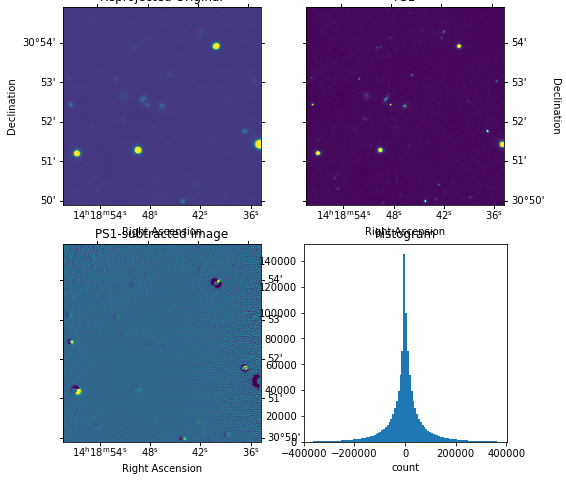

In [13]:
### Default
do_hotpants("temp.fits",REFILE,output="sub.fits", STR=None)

<a id='nsxy13'></a>
[nsx, nsy=13 param](#nsxy13p)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 1013.1525987884094 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 14781.44921875 -tg 1.2 -tr 5.2 -nsx 13 -nsy 13 -n i 
Mean:-0.38, Median:-0.35, 3-sigma std:0.80, std:2.93, std/3-sigma std:3.65


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


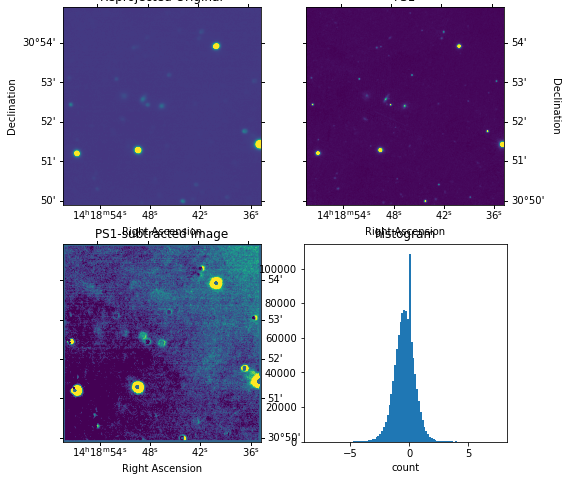

In [14]:
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,tu=TU,tl=TL,nsx=13,nsy=13,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 1013.1525987884094 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 14781.44921875 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-249.81, Median:0.00, 3-sigma std:183419.58, std:693654.38, std/3-sigma std:3.78


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


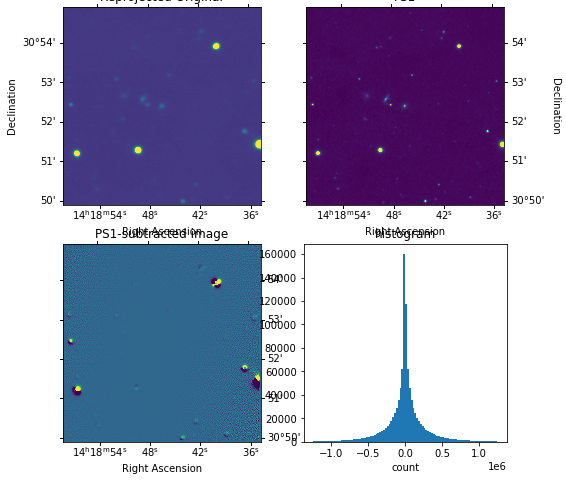

In [15]:
### iu, il, tu, tl を中心付近の領域での最大値、最小値を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,tu=TU,tl=TL,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 45000.0 -il -500.0 -iuk 45000.0 -ig 2.69 -ir 1.0 -tu 700.0 -tl -700.0 -tuk 700.0 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i  -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124
Mean:852.89, Median:0.00, 3-sigma std:623245.06, std:14534114.00, std/3-sigma std:23.32


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


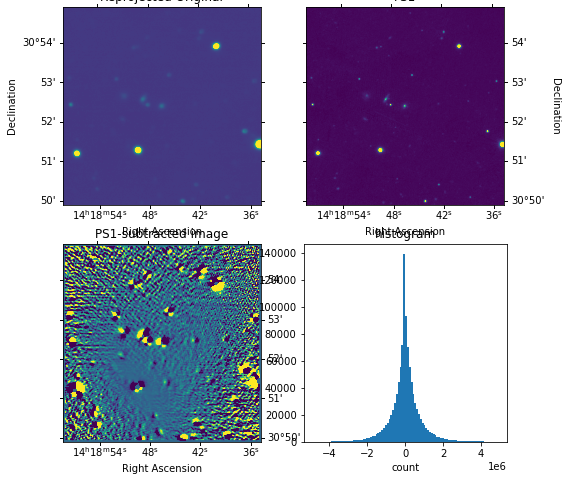

In [16]:
### -ng に推奨値を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",STR=ng)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 506.5762993942047 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 7390.724609375 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-249.81, Median:0.00, 3-sigma std:183419.58, std:693654.38, std/3-sigma std:3.78


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


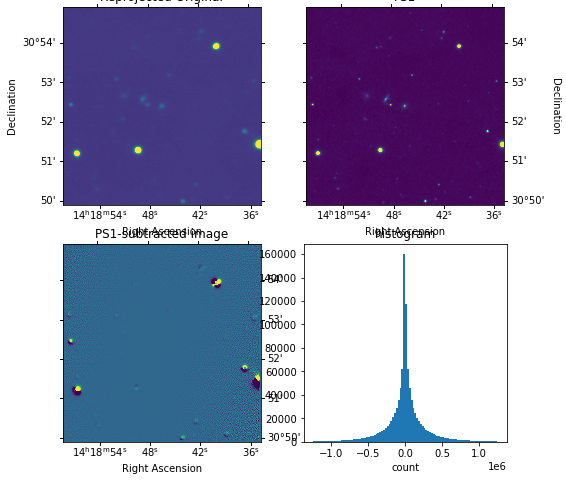

In [17]:
### iuk, tuk を最大値の半分に
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/2.,tu=TU,tl=TL,tuk=TU/2.,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 506.5762993942047 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 7390.724609375 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i  -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124
Mean:-963.16, Median:0.00, 3-sigma std:180298.11, std:27384518.00, std/3-sigma std:151.88


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


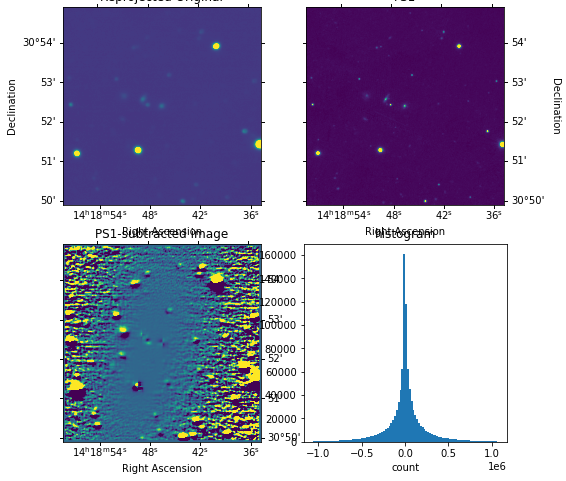

In [18]:
### iuk, tuk を最大値の半分にし、-ng を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/2.,tu=TU,tl=TL,tuk=TU/2.,STR=ng)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 2026.3051975768187 -il -502.9015323806237 -iuk 2026.3051975768187 -ig 2.69 -ir 1.0 -tu 29562.8984375 -tl -1180.0822143554688 -tuk 29562.8984375 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-26.52, Median:0.00, 3-sigma std:11850.37, std:45142.12, std/3-sigma std:3.81


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


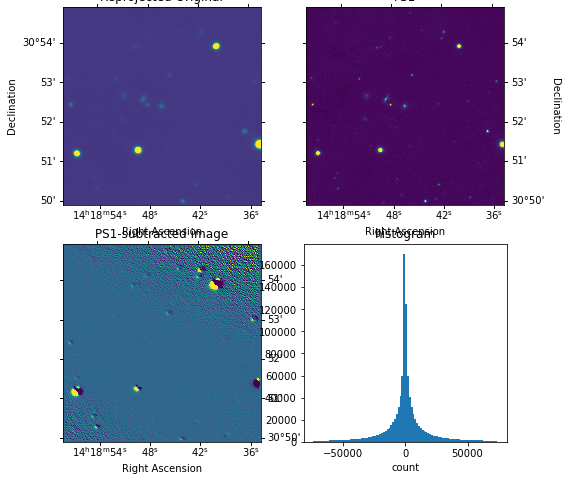

In [19]:
### iu, il, tu, tl を中心付近の領域での最大値、最小値を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU*2,il=IL,tu=TU*2,tl=TL,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 506.5762993942047 -il -502.9015323806237 -iuk 506.5762993942047 -ig 2.69 -ir 1.0 -tu 7390.724609375 -tl -1180.0822143554688 -tuk 7390.724609375 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-222.79, Median:0.00, 3-sigma std:181115.53, std:404245.47, std/3-sigma std:2.23


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


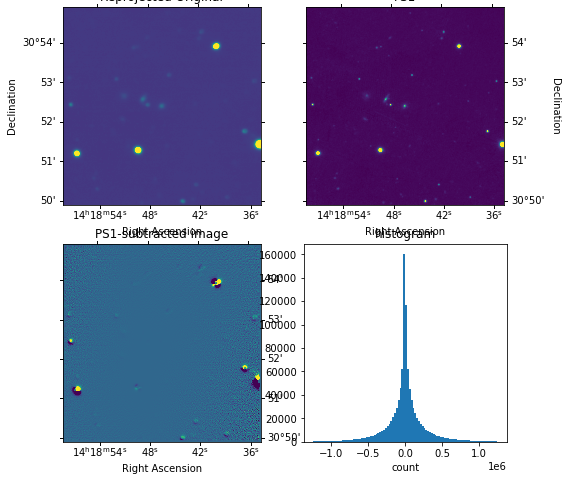

In [20]:
### iu, il, tu, tl を中心付近の領域での最大値、最小値を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU/2,il=IL,tu=TU/2,tl=TL,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 253.28814969710234 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 3695.3623046875 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-249.81, Median:0.00, 3-sigma std:183419.58, std:693654.38, std/3-sigma std:3.78


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


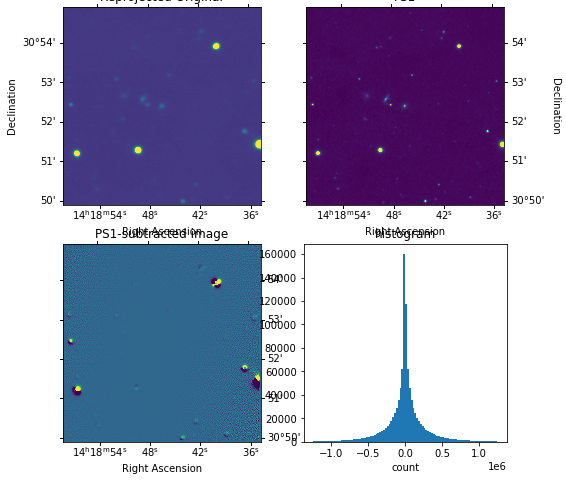

In [21]:
### iuk, tuk を最大値の半分にし、-ng を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/4.,tu=TU,tl=TL,tuk=TU/4.,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 253.28814969710234 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 3695.3623046875 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i  -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124
Mean:-963.16, Median:0.00, 3-sigma std:180298.11, std:27384518.00, std/3-sigma std:151.88


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


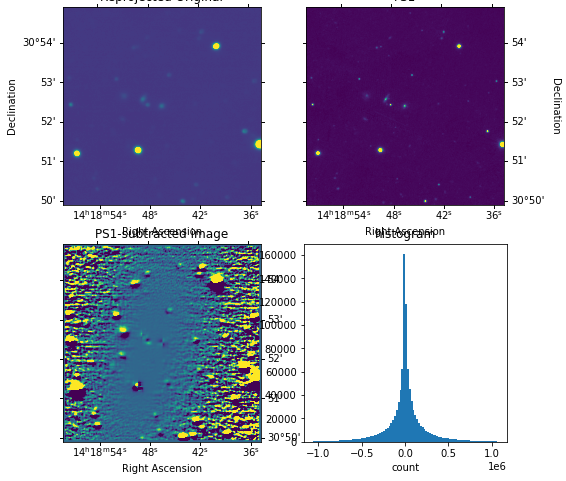

In [22]:
### iuk, tuk を最大値の半分にし、-ng を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/4.,tu=TU,tl=TL,tuk=TU/4.,STR=ng)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 253.28814969710234 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 3695.3623046875 -tg 1.2 -tr 5.2 -nsx 3 -nsy 3 -n i  -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124
Mean:-230749.69, Median:0.00, 3-sigma std:11596557.00, std:913403456.00, std/3-sigma std:78.77


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


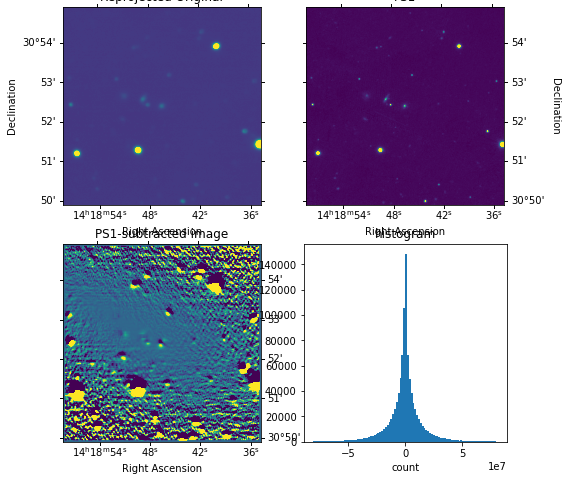

In [23]:
### iuk, tuk を最大値の半分にし、-ng を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/4.,tu=TU,tl=TL,tuk=TU/4.,nsx=3,nsy=3,STR=ng)

# nsx, nsy = 13 としたとき、他パラメータの影響を調査
<a id='nsxy13p'></a>
[nsx, nsy=13](#nsxy13)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 1013.1525987884094 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 14781.44921875 -tg 1.2 -tr 5.2 -nsx 13 -nsy 13 -n i 
Mean:-0.38, Median:-0.35, 3-sigma std:0.80, std:2.93, std/3-sigma std:3.65


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


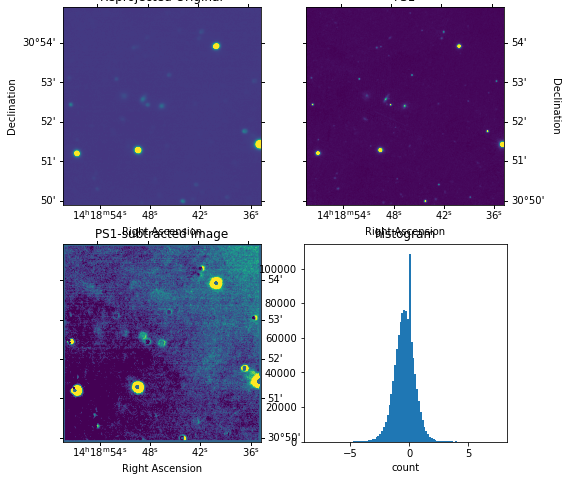

In [24]:
### iu, il, tu, tl を中心付近の領域での最大値、最小値を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,tu=TU,tl=TL,nsx=13, nsy=13,STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 45000.0 -il -500.0 -iuk 45000.0 -ig 2.69 -ir 1.0 -tu 700.0 -tl -700.0 -tuk 700.0 -tg 1.2 -tr 5.2 -nsx 13 -nsy 13 -n i  -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124


/Users/sasada/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in float_scalars
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Mean:0.00, Median:0.00, 3-sigma std:0.00, std:0.00, std/3-sigma std:nan


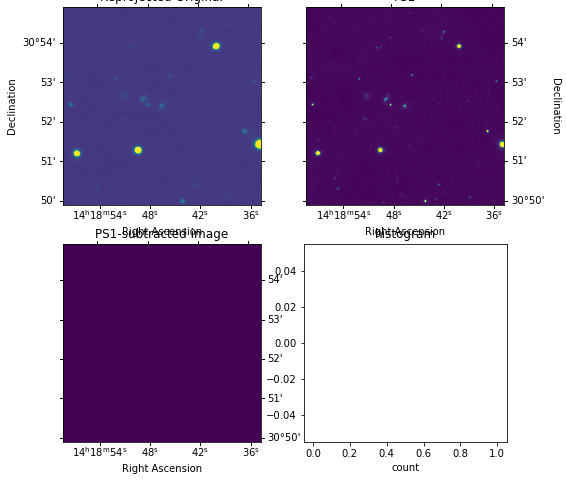

In [34]:
### -ng に推奨値を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",nsx=13, nsy=13, STR=ng)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 506.5762993942047 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 7390.724609375 -tg 1.2 -tr 5.2 -nsx 13 -nsy 13 -n i 
Mean:-0.41, Median:-0.37, 3-sigma std:0.85, std:2.64, std/3-sigma std:3.11


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


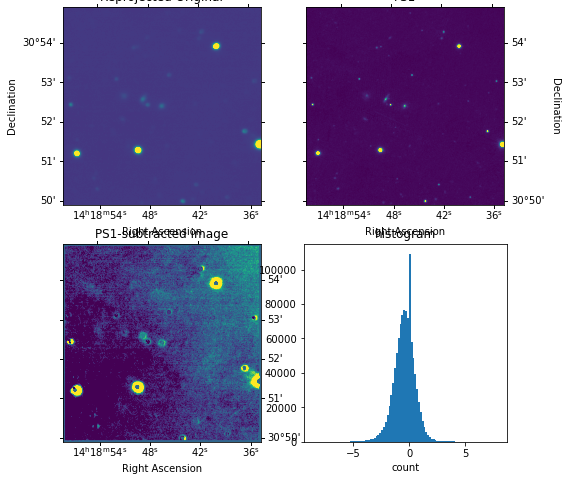

In [26]:
### iuk, tuk を最大値の半分に
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/2.,tu=TU,tl=TL,tuk=TU/2.,nsx=13, nsy=13, STR=None)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 506.5762993942047 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 7390.724609375 -tg 1.2 -tr 5.2 -nsx 13 -nsy 13 -n i  -ng 3 6 4.547136155742531 4 9.094272311485062 2 18.188544622970124
Mean:-1225137.38, Median:0.00, 3-sigma std:110751168.00, std:4313594880.00, std/3-sigma std:38.95


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


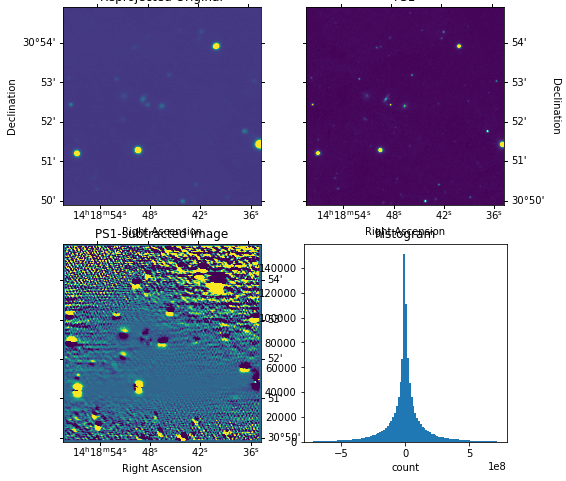

In [27]:
### iuk, tuk を最大値の半分にし、-ng を代入
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/2.,tu=TU,tl=TL,tuk=TU/2.,nsx=13, nsy=13, STR=ng)

hotpants -inim temp.fits -tmplim uploaded_20190412_21285538_GL141846plus305225_S190412m_ps1trim.fits -outim sub.fits -iu 1013.1525987884094 -il -502.9015323806237 -iuk 10.131525987884094 -ig 2.69 -ir 1.0 -tu 14781.44921875 -tl -1180.0822143554688 -tuk 1478.144921875 -tg 1.2 -tr 5.2 -nsx 10 -nsy 10 -n i 
Mean:-158.18, Median:0.00, 3-sigma std:167934.61, std:313853.97, std/3-sigma std:1.87


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


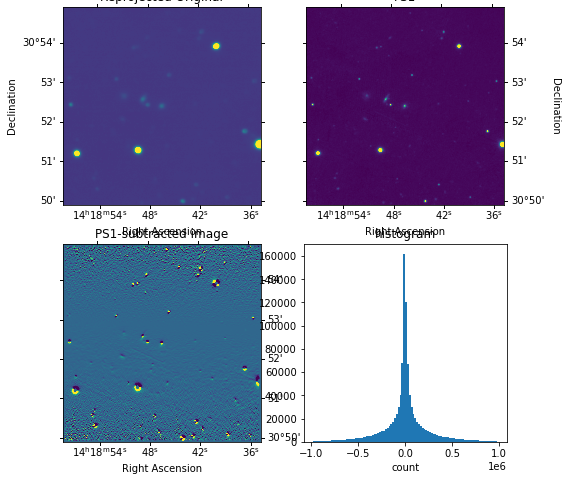

In [46]:
do_hotpants("temp.fits",REFILE,output="sub.fits",iu=IU,il=IL,iuk=IU/100.,tu=TU,tl=TL,tuk=TU/10.,nsx=10, nsy=10, STR=None)